In [88]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [121]:
#pip install ipython-autotime

Note: you may need to restart the kernel to use updated packages.


In [123]:
%load_ext autotime
%load_ext autoreload
%autoreload 2
import os
import sys
sys.path.insert(0, os.path.abspath('../src/'))

The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
time: 1.27 ms (started: 2021-07-06 08:12:54 +02:00)


In [90]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from structure_factor.structure_factor_new import StructureFactor
from structure_factor.spatstat_interface import SpatstatInterface
from structure_factor.spatial_windows import UnitBoxWindow


# testing the calss StructureFactor

In [108]:
#importing big data
import pickle
import rpy2.robjects as robjects
with open('/Users/dhawat/github/structure-factor/data/data_big_intensity.dat', 'rb') as pickle_file:
    r_poisson, n_pois, poisson, push, equi, t_max, t_max_e = pickle.load(pickle_file, encoding="bytes")

with open('/Users/dhawat/github/structure-factor/data/big_gin_1.dat', 'rb') as pickle_file_2:
    n_ginibre, ginibre = pickle.load(pickle_file_2, encoding="bytes")

robjects.r['load']("/Users/dhawat/github/structure-factor/data/data_klatt_2.dat")
data_R_2 = robjects.r['out_2']
data_kly_all = np.array(data_R_2)

In [109]:
print("data_kly.shape", data_kly_all.shape)
print("data_poisson.shape", poisson.shape)
print("data_ginibre.shape", ginibre.shape )

data_klatt.shape (90000, 4)
data_poisson.shape (808678, 1)
data_ginibre.shape (10000, 1)


In [110]:
#load big data in the corresponding shape :math: `n /times 2`
data_poisson = np.array([np.array(np.real(poisson)).reshape(-1,), np.array(np.imag(poisson)).reshape(-1,)]).T
data_ginibre = np.array([np.array(np.real(ginibre)).reshape(-1,), np.array(np.imag(ginibre)).reshape(-1,)]).T
data_kly = np.array([data_kly_all[:,0], data_kly_all[:,1]]).T
data_z_2 = np.array([data_kly_all[:,2], data_kly_all[:,3]]).T

In [111]:
#verifying the shape
print("data_klatt.shape", data_klatt.shape)
print("data_ginibre.shape", data_ginibre.shape )

data_klatt.shape (90000, 2)
data_ginibre.shape (10000, 2)


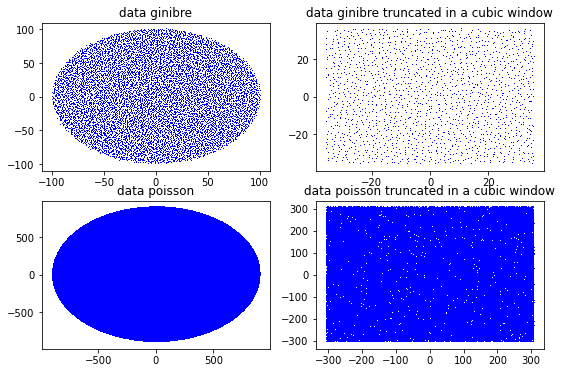

In [112]:
# truncating data_poisson and Ginibre in a cubic window
# poisson, and ginibre are contained in a ball while klatt and z_2 are in a rectangular window L = 300
raduis_poisson = np.max(np.abs(poisson)) -32
L_poisson = np.floor(raduis_poisson/np.sqrt(2))
index_poisson_in_cube = np.logical_and((np.abs(data_poisson[:,0]) < (L_poisson/2)) , (np.abs(data_poisson[:,1]) < (L_poisson/2)))
data_poisson_cube = data_poisson[index_poisson_in_cube]

raduis_ginibre = np.max(np.abs(ginibre))
L_ginibre = raduis_ginibre/np.sqrt(2)
index_ginibre_in_cube = np.logical_and((np.abs(data_ginibre[:,0]) < L_ginibre/2) , (np.abs(data_ginibre[:,1]) < L_ginibre/2))
data_ginibre_cube = data_ginibre[index_ginibre_in_cube]

fig, ax = plt.subplots(2, 2, figsize=(9,6))
ax[0,0].plot(data_ginibre[:,0], data_ginibre[:,1], 'b,')
ax[0,0].title.set_text("data ginibre")
ax[0,1].plot(data_ginibre_cube[:,0], data_ginibre_cube[:,1], 'b,')
ax[0,1].title.set_text("data ginibre truncated in a cubic window")
ax[1,0].plot(data_poisson[:,0], data_poisson[:,1], 'b,')
ax[1,0].title.set_text("data poisson")
ax[1,1].plot(data_poisson_cube[:,0], data_poisson_cube[:,1], 'b,')
ax[1,1].title.set_text("data poisson truncated in a cubic window")

In [113]:
sf_poisson = StructureFactor(data_poisson, intensity=1/np.pi )
sf_poisson_cube = StructureFactor(data_poisson_cube, intensity=1/np.pi )

sf_ginibre = StructureFactor(data_ginibre, intensity=1/np.pi )
sf_ginibre_cube = StructureFactor(data_ginibre_cube, intensity = 1/np.pi )

sf_kly = StructureFactor(data_kly, intensity= 1)
sf_z_2 = StructureFactor(data_z_2, intensity=1)

## test the method get ``compute_scattering_intensity`` of the calss StructureFactor

# for Poisson point process
we know that the pair correlation function and the structure factor of the Poisson point process are equal to 1 so we always plot the line  $𝑦=1$  representing the théoretical values for a Poisson point process

In [11]:
wave_length_poisson, scattering_intensity_poisson = sf_poisson_cube.compute_scattering_intensity(L=L_poisson,maximum_k =10,meshgrid_size=None)

the method ``plot_scattering_intensity`` take as input the output of the method ``compute_scattering_intensity`` to plot them.
also take as optional argument ``binning_parameter``correspnding to the parameters used for binning of ``si``, and ``exact_sf`` which the true sctructure factor function

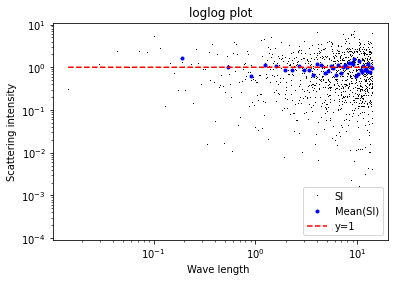

In [12]:
sf_poisson_cube.plot_scattering_intensity(wave_length_poisson.ravel(), scattering_intensity_poisson.ravel(), bins=40)

In [18]:
wave_length_poisson, scattering_intensity_poisson = sf_poisson_cube.compute_scattering_intensity(L=L_poisson,maximum_k =10,meshgrid_size=100)

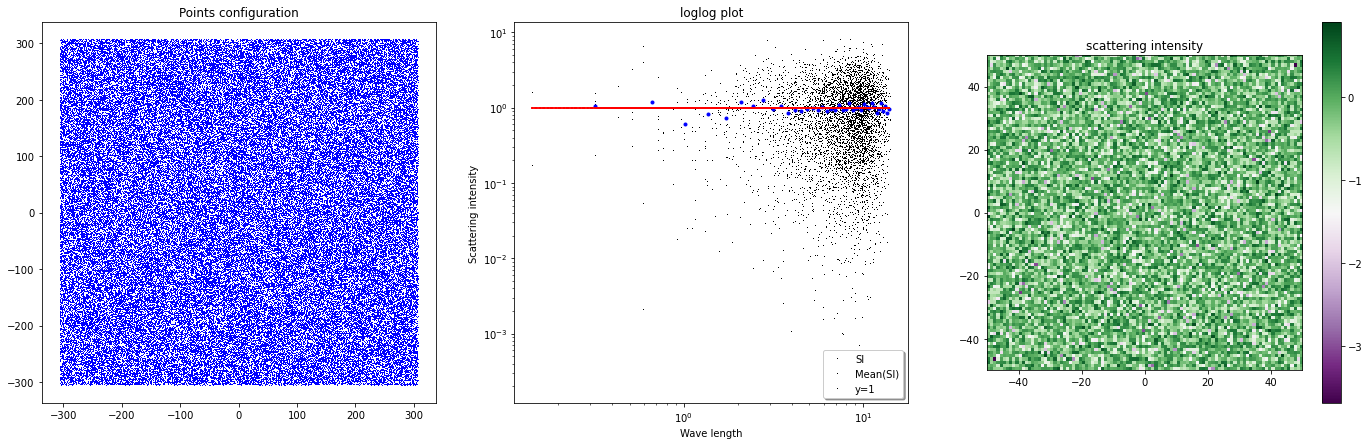

In [19]:
sf_poisson_cube.plot_scattering_intensity(wave_length_poisson, scattering_intensity_poisson, plot_type="all",  bins=40, )

# for Ginibre point process

In [102]:
exact_pcf_ginibre = lambda x : 1 - np.exp(-x**2) # exact pcf of the Ginibre point process
exact_h_ginibre = lambda x : - np.exp(-x**2) # exact total correlation fucntion for the Ginibre point processs
exact_sf_ginibre = lambda x : 1 - np.exp(-x**2/4) # exact structure factor for the Ginibre point process

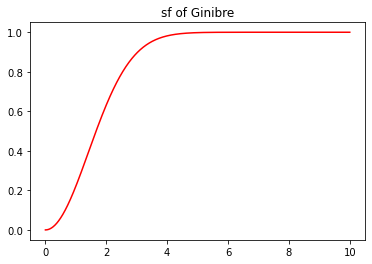

In [103]:
x=np.linspace(0,10, 1000)
plt.plot(x, exact_sf_ginibre(x), 'r')
plt.title("sf of Ginibre")
plt.show()

In [97]:
norm_k_ginibre, scattering_intensity_ginibre = sf_ginibre_cube.compute_scattering_intensity(L=L_ginibre,maximum_k =20)


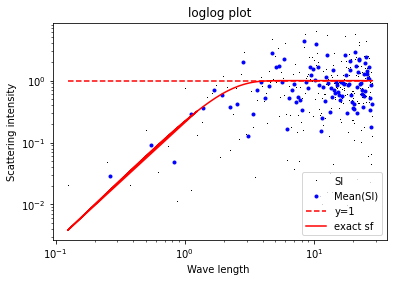

In [100]:
sf_ginibre_cube.plot_scattering_intensity(norm_k_ginibre, scattering_intensity_ginibre, plot_type="plot", exact_sf= exact_sf_ginibre, bins=100 )

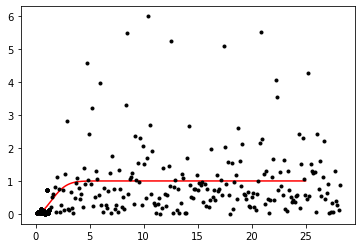

In [101]:
x=np.linspace(0,25, 1000)
plt.plot(x, exact_sf_ginibre(x), 'r', label="exat sf ginibre ")
plt.plot(norm_k_ginibre, scattering_intensity_ginibre, 'k.')
plt.show()

In [106]:
norm_k_ginibre_, scattering_intensity_ginibre_ = sf_ginibre_cube.compute_scattering_intensity(L=L_ginibre,maximum_k =10,meshgrid_size=300)

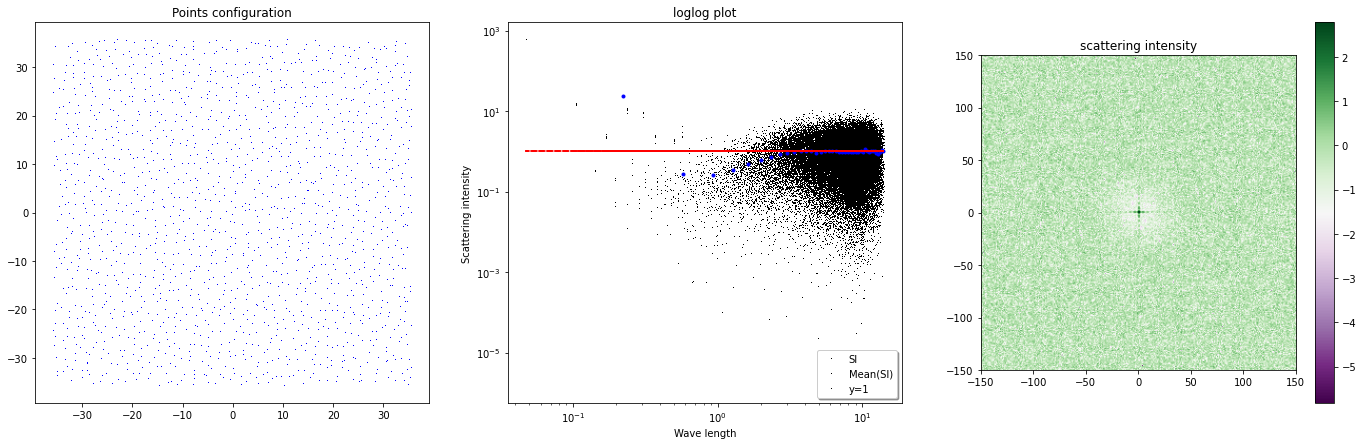

In [107]:
sf_ginibre_cube.plot_scattering_intensity(norm_k_ginibre_, scattering_intensity_ginibre_, plot_type="all", bins=40 )

# for the processus of  Michael Andreas Klatt, Günter Last, D. Yogeshwaran that we will denoted by kly defined in https://arxiv.org/abs/1810.00265

In [114]:
norm_k_kly, si_kly = sf_kly.compute_scattering_intensity(L=300, maximum_k=20)

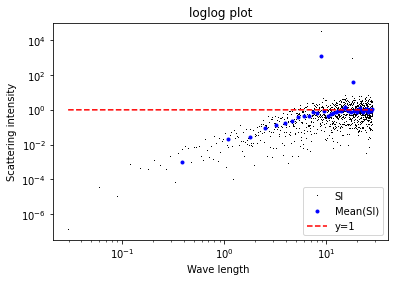

In [115]:
sf_kly.plot_scattering_intensity(norm_k_kly, si_klatt, plot_type="plot", bins=40 )

In [124]:
norm_k_kly_, si_kly_ = sf_kly.compute_scattering_intensity(L=300, maximum_k=10, meshgrid_size=150)

time: 7min 28s (started: 2021-07-06 08:13:33 +02:00)


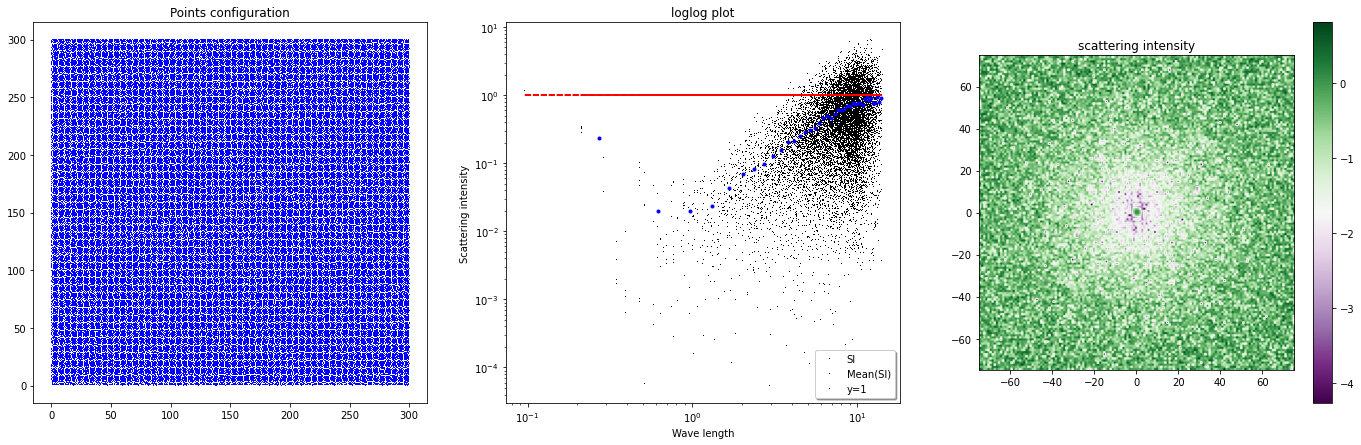

time: 1.67 s (started: 2021-07-06 08:25:33 +02:00)


In [125]:
sf_kly.plot_scattering_intensity(norm_k_kly_, si_kly_, plot_type="all", bins=40)

# for a lattice $\mathbb{Z}^2$

In [126]:
norm_k_z2, si_z2 = sf_z_2.compute_scattering_intensity(L=300, maximum_k=50)

time: 7.52 s (started: 2021-07-06 10:05:40 +02:00)


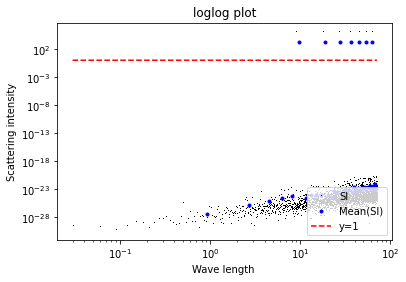

time: 375 ms (started: 2021-07-06 10:05:50 +02:00)


In [127]:
sf_z_2.plot_scattering_intensity(norm_k_z2, si_z2, plot_type="plot", bins=40 )

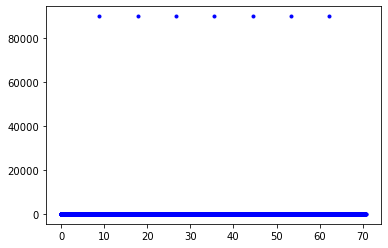

time: 104 ms (started: 2021-07-06 10:06:07 +02:00)


In [128]:
plt.plot(norm_k_z2, si_z2, 'b.')

In [129]:
norm_k_z2_, si_z2_ = sf_z_2.compute_scattering_intensity(L=300, maximum_k=20, meshgrid_size=150)

time: 7min 21s (started: 2021-07-06 10:07:14 +02:00)


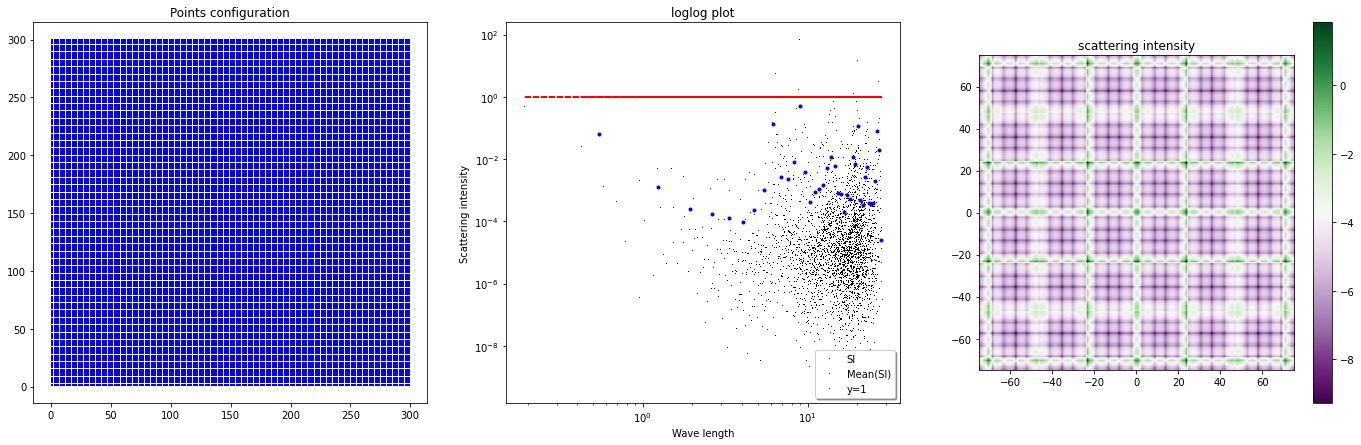

time: 1.12 s (started: 2021-07-06 10:15:08 +02:00)


In [130]:
sf_z_2.plot_scattering_intensity(norm_k_z2_, si_z2_, plot_type="all", bins=40)